In [ ]:
#librerias y funciones
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import pytesseract as tess
tess.pytesseract.tesseract_cmd = r'C:\Users\Patri\AppData\Local\Tesseract-OCR\tesseract.exe'
# ^es la forma que encontre de que me ande el tess, perdon por lo bruto :)
# entiendo que hay que poner en donde esta instalado el tesseract o algo asi

#importo un archivo png, x ej: paint1.png'
def import_grayscale_img(archivo):
    img = cv.cvtColor(cv.imread(archivo), cv.COLOR_BGR2GRAY)
    return img

def box_params(h,w,b,ampliar):
#es llamado por get_boxes. Prepara los x,y de las bounding boxes
#b es un vector con strings tipo '100', '78',
#que sale de splitear lo que devuelve tess.image_to_boxes
    box_height = (int(b[4])-int(b[2]))*ampliar
    avg_height = ((h-int(b[4]))+(h-int(b[2])))/2
    box_width = (int(b[3])-int(b[1]))*ampliar
    avg_width = (int(b[3])+int(b[1]))/2
    x1 = int(avg_height - box_height/2)
    x2 = int(avg_height + box_height/2)
    y1 = int(avg_width - box_width/2)
    y2 = int(avg_width + box_width/2)
    if x1<0:
        x1=0
    if x2>h:
        x2=h
    if y1<0:
        y1=0
    if y2>w:
        y2=w
    return x1,x2,y1,y2

def get_boxes(img,ampliar=1,plot=False,grilla=False):
#dada una img, separa los caracteres poniendo cada uno en otra image.
#me devuelve un vector con esas imagenes.
#el 'ampliar' es xq a veces, tesseract hace las boxes muy pegadas al caracter.
#Puede servir ponerlo en 1.2, 1.5 aprox
    chars_img = []
    temp = []
    boxes = tess.image_to_boxes(img, lang="eng+equ")
    h, w = img.shape
    for b in boxes.splitlines():
        b = b.split(' ')
        x1,x2,y1,y2 = box_params(h,w,b,ampliar)
        temp = np.copy(img[x1:x2,y1:y2])
        chars_img.append(temp)
    if plot==True:
        plot_img(img)  
        plot_subimg(chars_img,grilla=grilla)
    return chars_img


def plot_img(img):
    #plotea en blanco y negro
    plt.imshow(img,'gray')
    plt.show()
    
    
def plot_subimg(subimg_array,grilla=False):
    #plotea las img de cada caracter, una abajo de la otra o en un
    #subplot (grilla)
    if grilla==True:
        a = int(np.ceil(np.sqrt(np.shape(subimg_array)[0])))
        i=1
        for image in subimg_array:
            plt.subplot(a,a,i)
            plt.imshow(image,'gray')
            i += 1
        plt.show()
    else:
        for image in subimg_array:
            plt.imshow(image,'gray')
            plt.show()
    

def resize_boxes(h,w,img,write=False,name='prueba1.png'):
    #cambia el tamaño de las img de los caracteres.
    #Write==True las guarda en carpeta.
    out_img = cv.resize(img,(h,w))
    if write==True:
        cv.imwrite(name,out_img)
    return out_img

In [ ]:
#mas funciones:

#limpiado de imagen
#uso median blur, 7 iteraciones y entiendo que con un kernel de 5x5
#^es lo que mejor me quedo. Para mas info, ver 'jugando con limpiado de imagenes'

def limpiar(img,iter=7,kernel_size=5):
    for i in range(iter):
        img = cv.medianBlur(img,kernel_size)
    return img


def draw_img(height=300,width=600):
#Te abre una ventana para dibujar en negro. Se sale apretando 'q'. Devuelve la img dibujada.
    drawing = False
    prevx, prevy = None,None
    img = (np.ones((height,width), np.uint8)*255)  #Creo una imagen en blanco
    cv.namedWindow('Canvas')             #La llamo canvas
    cv.setMouseCallback('Canvas',draw_circle, img)  #Seteo los callbacks para el mouse
    while True:
        cv.imshow('Canvas',img)
        if cv.waitKey(20) & 0xFF == ord('q'):
            break
    cv.destroyAllWindows()
    return img

def draw_circle(event,x,y,flags,param):
    #FUNCION CALLBACK DE MANEJO DE EVENTOS DE MOUSE
    #es llamada por draw_img
    global drawing #Me dice si tengo el mouse apretado
    global prevx #Posicion x anterior
    global prevy #posicion y anterior
    img = param
    if event == cv.EVENT_LBUTTONDOWN:         #Cuando apreto el mouse, dibujo un circulo en el lugar
        drawing = True                         #y guardo la posicion
        img = cv.circle(img,(x,y),1,(0,0,0), -1)
        prevx, prevy = x, y
    elif event == cv.EVENT_MOUSEMOVE:         #Cuando muevo el mouse, me fijo si el mouse sigue apretado
        if drawing == True:                    #Si lo esta, dibujo una linea desde la posiciona anterior a la actual
            img = cv.line(img,(prevx, prevy),(x,y),(0, 0, 0), 2)
            prevx, prevy = x, y
    elif event == cv.EVENT_LBUTTONUP:        #Cuando suelto el boton dibujo una ultima linea
        drawing = False
        img = cv.line(img,(prevx, prevy),(x,y),(0, 0, 0), 2)
        prevx, prevy = None,None


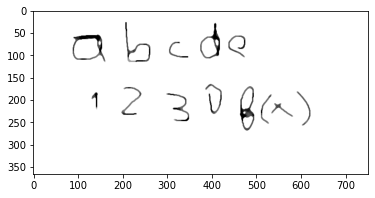

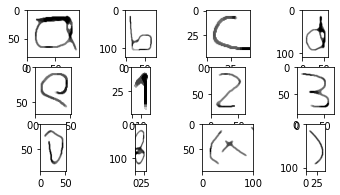

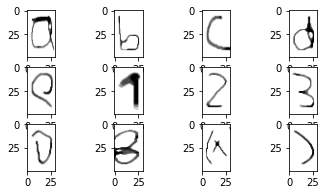

In [ ]:
#ejemplo del uso de las funciones:
img = import_grayscale_img('paint1.png')
img = limpiar(img)
chars_img = get_boxes(img,1.4,plot=True,grilla=True)
out_img = [] #aca meto las imagenes resizeadas
i=1
for char_img in chars_img:
    name= 'caracter'+str(i)+'.png'
    i+=1
    temp = resize_boxes(30,50,char_img,write=False,name=name)
    #guarda que si write=True, te guarda por separado todos los caracteres q encuentra
    out_img.append(temp)
plot_subimg(out_img,grilla=True)

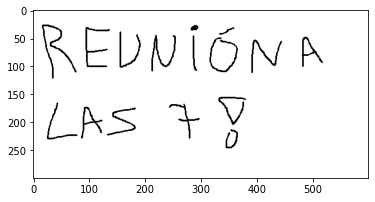

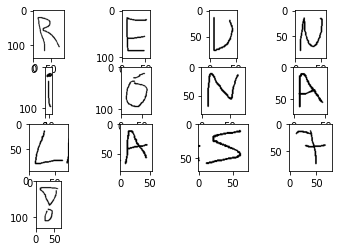

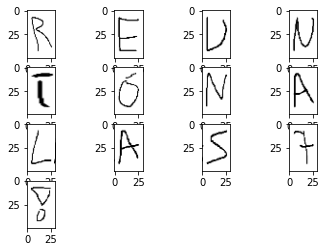

In [ ]:
#otro ejemplo:
img = draw_img()
#img = limpiar(img) #si va a escribir uno, mejor no hacer el blur.
                    #total, la img no va a tener ruido.
chars_img = get_boxes(img,1.4,plot=True,grilla=True)
out_img = [] #aca meto las imagenes resizeadas
i=1
for char_img in chars_img:
    name= 'caracter'+str(i)+'.png'
    i+=1
    temp = resize_boxes(30,50,char_img,write=False,name=name)
    #guarda que si write=True, te guarda por separado todos los caracteres q encuentra
    out_img.append(temp)
plot_subimg(out_img,grilla=True)